In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase


In [2]:
disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')
gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
gen_weighted_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_pred-opt_modular_part2_raw.npy')
disc_weighted_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_disc_pred-opt_modular_part2_raw.npy')
real = np.load('/user/home/al18709/work/gan_predictions_20/validation_real-opt_modular_part2_raw.npy')
# disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_patchloss_raw.npy')
# gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_patchloss_raw.npy')

inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


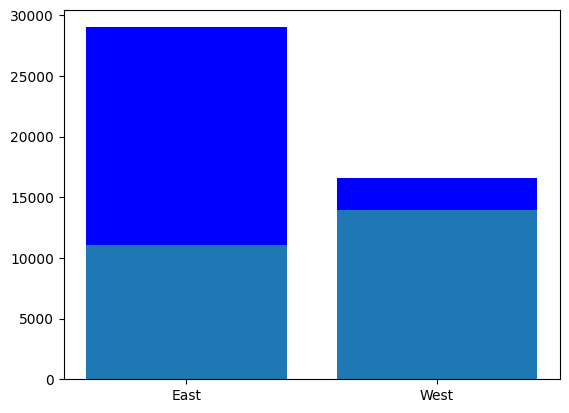

In [3]:
training_lons = training_inputs[:,5]
training_mslp = training_inputs[:,0]
mean_slp = np.mean(training_mslp)
west = np.sum(training_lons < 0)
east = np.sum(training_lons > 0)

west_strong = np.sum((training_lons < 0) & (training_mslp<mean_slp))
west_weak = np.sum((training_lons < 0) & (training_mslp>mean_slp))

east_strong = np.sum((training_lons > 0) & (training_mslp<mean_slp))
east_weak = np.sum((training_lons > 0) & (training_mslp>mean_slp))
plt.bar(['East','West'],[east_weak,west_weak])
plt.bar(['East','West'], [east_strong,west_strong], bottom=[east_weak,west_weak], color='b')
plt.show()


In [4]:
print(disc_pred.shape)
print(inputs.shape)

(15930, 1, 20)
(15930, 6)


In [5]:
print(disc_pred[10,0,2])

11.16907024383545


/tmp/ipykernel_155881/45693323.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_pred[:,0,0], shade=True, color="#3E579C")


/tmp/ipykernel_155881/45693323.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_weighted_pred[:,0,0], shade=True)


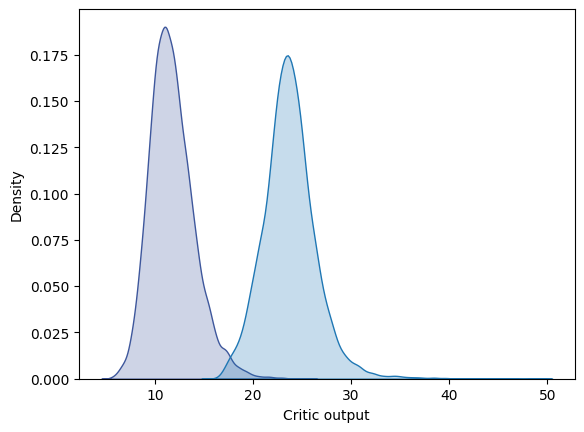

In [6]:
# sns.set_style("whitegrid")  # You can change the style to your preference
sns.kdeplot(disc_pred[:,0,0], shade=True, color="#3E579C")
sns.kdeplot(disc_weighted_pred[:,0,0], shade=True)
# plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Critic output")
plt.ylabel("Density")
plt.show()

In [7]:
percentiles = np.arange(0,100,10)
pred_p = np.percentile(disc_pred[:,0,0], percentiles)
pred_pw = np.percentile(disc_weighted_pred[:,0,0], percentiles)
min = np.min(disc_pred[:,0,0])
max = np.max(disc_pred[:,0,0])
minw = np.min(disc_weighted_pred[:,0,0])
maxw = np.max(disc_weighted_pred[:,0,0])
limits = [0] * 10
limits[-1] = max
limits[0:-1] = pred_p
limitsw = [0] * 10
limitsw[-1] = maxw
limitsw[0:-1] = pred_pw

In [8]:
print(pred_p)
print(limits)

[ 5.51217461  9.06677523  9.83350048 10.40375099 10.93907909 11.45340633
 12.01423588 12.64410219 13.44328556 14.69338303]
[5.512174606323242, 9.066775226593018, 9.833500480651855, 10.403750991821289, 10.939079093933106, 11.45340633392334, 12.014235877990723, 12.644102191925048, 13.443285560607912, 14.693383026123048, 25.534744262695312]


In [9]:

p_10 = inputs[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:]
p_20 = inputs[(disc_pred[:,0,0] > limits[1]) & (disc_pred[:,0,0] < limits[2]),:]
p_30 = inputs[(disc_pred[:,0,0] > limits[2]) & (disc_pred[:,0,0] < limits[3]),:]
p_40 = inputs[(disc_pred[:,0,0] > limits[3]) & (disc_pred[:,0,0] < limits[4]),:]
p_50 = inputs[(disc_pred[:,0,0] > limits[4]) & (disc_pred[:,0,0] < limits[5]),:]
p_60 = inputs[(disc_pred[:,0,0] > limits[5]) & (disc_pred[:,0,0] < limits[6]),:]
p_70 = inputs[(disc_pred[:,0,0] > limits[6]) & (disc_pred[:,0,0] < limits[7]),:]
p_80 = inputs[(disc_pred[:,0,0] > limits[7]) & (disc_pred[:,0,0] < limits[8]),:]
p_90 = inputs[(disc_pred[:,0,0] > limits[8]) & (disc_pred[:,0,0] < limits[9]),:]
p_100 = inputs[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:]

pw_10 = inputs[(disc_weighted_pred[:,0,0] > limitsw[0]) & (disc_weighted_pred[:,0,0] < limitsw[1]),:]
pw_20 = inputs[(disc_weighted_pred[:,0,0] > limitsw[1]) & (disc_weighted_pred[:,0,0] < limitsw[2]),:]
pw_30 = inputs[(disc_weighted_pred[:,0,0] > limitsw[2]) & (disc_weighted_pred[:,0,0] < limitsw[3]),:]
pw_40 = inputs[(disc_weighted_pred[:,0,0] > limitsw[3]) & (disc_weighted_pred[:,0,0] < limitsw[4]),:]
pw_50 = inputs[(disc_weighted_pred[:,0,0] > limitsw[4]) & (disc_weighted_pred[:,0,0] < limitsw[5]),:]
pw_60 = inputs[(disc_weighted_pred[:,0,0] > limitsw[5]) & (disc_weighted_pred[:,0,0] < limitsw[6]),:]
pw_70 = inputs[(disc_weighted_pred[:,0,0] > limitsw[6]) & (disc_weighted_pred[:,0,0] < limitsw[7]),:]
pw_80 = inputs[(disc_weighted_pred[:,0,0] > limitsw[7]) & (disc_weighted_pred[:,0,0] < limitsw[8]),:]
pw_90 = inputs[(disc_weighted_pred[:,0,0] > limitsw[8]) & (disc_weighted_pred[:,0,0] < limitsw[9]),:]
pw_100 = inputs[(disc_weighted_pred[:,0,0] > limitsw[9]) & (disc_weighted_pred[:,0,0] < limitsw[10]),:]


[0.00084843]


[0.00114688 0.00151614 0.00196201 0.00249466 0.00312007 0.00383663
 0.00463294 0.00548895 0.00638317 0.00730584 0.0082739  0.00934081
 0.01059423 0.01213793 0.01406076 0.01640574 0.01915847 0.02226685
 0.02568309 0.02940002 0.03345585 0.03790602 0.04278535 0.04808639
 0.05376253 0.05974778 0.06598289 0.07243999 0.07913503 0.08611453
 0.09341598 0.10102574]
[5.62077135 5.73141591 5.84206047 5.95270503 6.06334959 6.17399415
 6.28463871 6.39528327 6.50592783 6.61657239 6.72721695 6.83786151
 6.94850607 7.05915063 7.16979519 7.28043975 7.39108431 7.50172887
 7.61237343 7.72301798 7.83366254 7.9443071  8.05495166 8.16559622
 8.27624078 8.38688534 8.4975299  8.60817446 8.71881902 8.82946358
 8.94010814 9.0507527 ]
0.0008484271213095687 0.10214935082384373
[0.10886642 0.11682458 0.12479551 0.13270804 0.14050988 0.14812522
 0.15541729 0.16218733 0.16822048 0.17335991 0.17756946 0.18094656
 0.18367285 0.1859236  0.18777962 0.18918781 0.18999687 0.19005727
 0.18933186 0.18794455 0.18612527 0.184

/tmp/ipykernel_155881/1532996034.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_pred[:,0,0], shade=False, color="#3E579C")


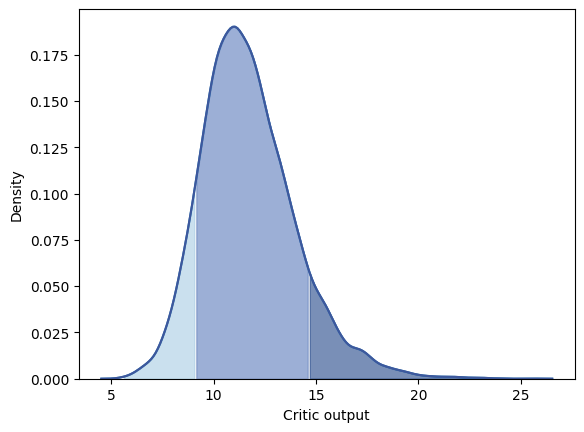

In [10]:
# sns.set_style("whitegrid")  # You can change the style to your preference
kde = gaussian_kde(disc_pred[:,0,0])
kdew = gaussian_kde(disc_weighted_pred[:,0,0])

colours = ["#A8CCE3","#98B5D9","#89A0CF", "#799AC5", "#6A88BB", "#5B78B0","#4C67A6", "#3E579C","#2F4792","#204587","black"]
print(kde.evaluate(limits[0]))
x_kde, y_kde = sns.kdeplot(disc_pred[:,0,0]).get_lines()[0].get_data()
# x_kdew, y_kdew = sns.kdeplot(disc_weighted_pred[:,0,0]).get_lines()[0].get_data()

for i in range(10):
	if i in range(1,9):
		y = y_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
		x = x_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
		print(y)
		print(x)
		plt.fill_between(x,y, color=colours[2], alpha=0.2)
		continue
	[y1] = kde.evaluate(limits[i])
	[y2] = kde.evaluate(limits[i+1])
	y = y_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
	x = x_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
	print(y)
	print(x)
	plt.fill_between(x,y, color=colours[i], alpha=0.6)
	line1_x = limits[i]
	line2_x = limits[i+1]
	print(y1,y2)
	y2 = np.maximum(y1,y2)
	y1 = np.minimum(y1,y2)
	# plt.fill_betweenx([0,y2], line1_x, x2=line2_x, color=colours[i], alpha=0.6)
	# plt.plot([limits[i],limits[i]],[0,y1],color=colours[i],fill=True)


# [y_max] = kde.evaluate(np.mean(disc_pred[:,0,0]))


# plt.fill_betweenx(y_kde, x_kde, color='orange', alpha=0.4, label='Opposite Area')
# 
sns.kdeplot(disc_pred[:,0,0], shade=False, color="#3E579C")
# plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Critic output")
plt.ylabel("Density")
plt.show()

In [11]:
print(p_10.shape)
print(p_100.shape)

(1592, 6)
(1592, 6)


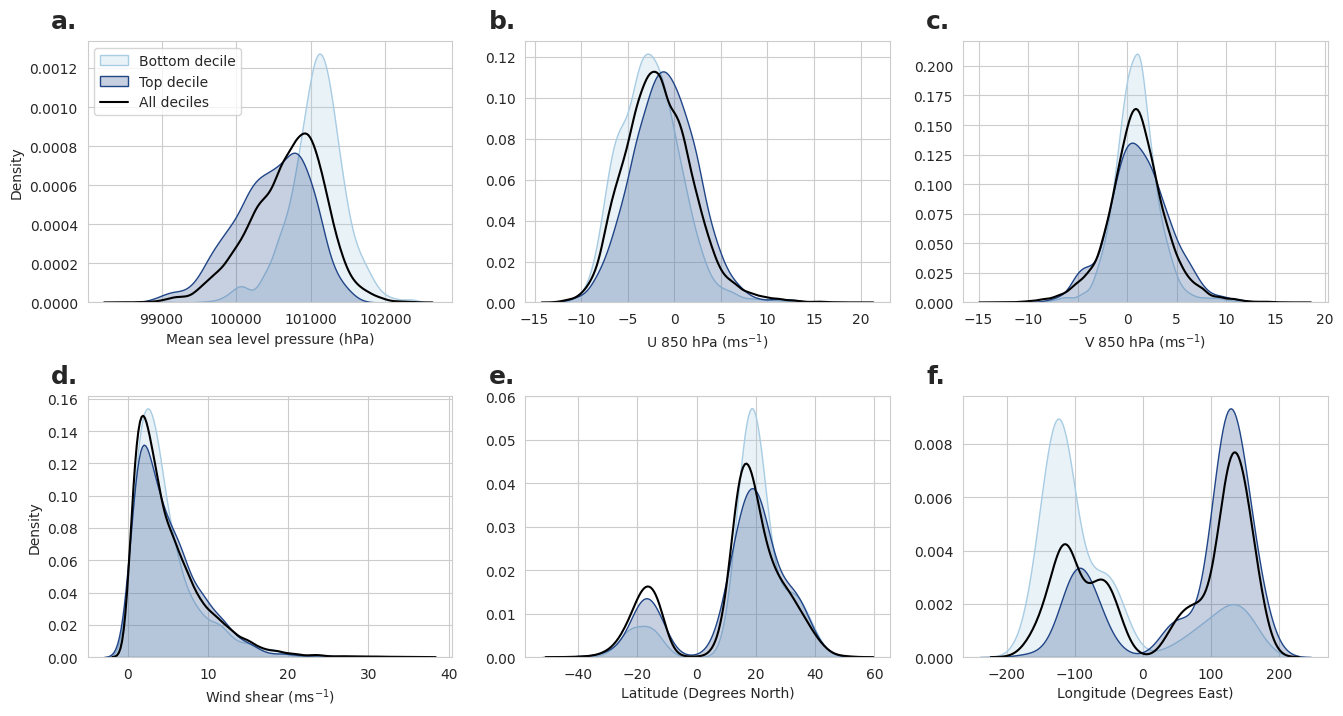

In [12]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(p_10[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(p_60[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    sns.kdeplot(p_100[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
axes[0,0].legend(['Bottom decile','Top decile','All deciles'],loc='upper left')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_9a_inputs_4.png',bbox_inches='tight',dpi=600)

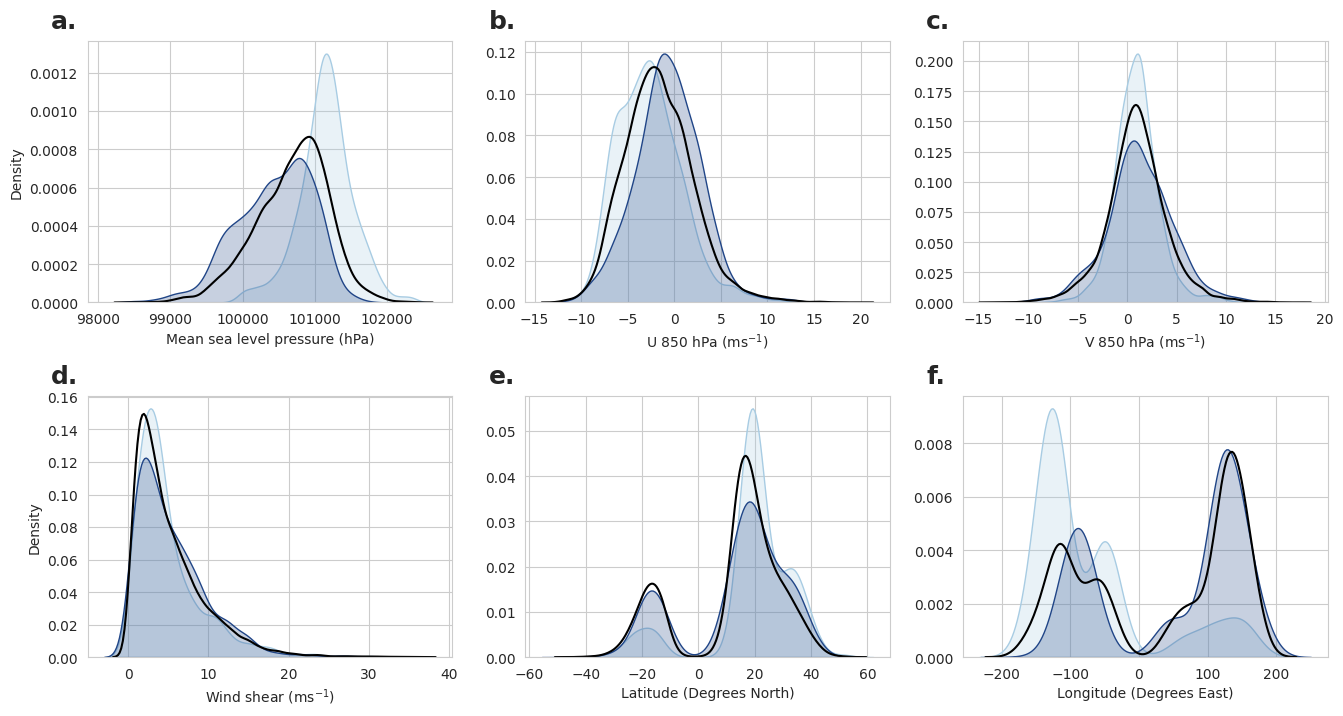

In [13]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(pw_10[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(p_60[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    sns.kdeplot(pw_100[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_9a_weighted_inputs_4.png',bbox_inches='tight',dpi=600)

In [14]:
pred_10 = gen_pred[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:,:]
pred_100 = gen_pred[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:,:]

In [15]:
sns.set_style("white")
height_ratios = [1,0.01,1]
n = 3
m = 6
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.5, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

		# axes[j,0].spines['bottom'].set_visible(False)
		# axes[j,0].spines['top'].set_visible(False)
		# axes[j,0].spines['left'].set_visible(False)
		# axes[j,0].spines['right'].set_visible(False)
		# axes[j,-1].spines['bottom'].set_visible(False)
		# axes[j,-1].spines['top'].set_visible(False)
		# axes[j,-1].spines['left'].set_visible(False)
		# axes[j,-1].spines['right'].set_visible(False)

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

storms = np.random.randint(0,1000,6)
print(storms)
	
im = axes[0,0].imshow(pred_10[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(pred_10[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(pred_10[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(pred_10[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,3].invert_yaxis()
axes[0,4].imshow(pred_10[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,4].invert_yaxis()
axes[0,5].imshow(pred_10[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,5].invert_yaxis()

axes[2,0].imshow(pred_100[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,0].invert_yaxis()
axes[2,1].imshow(pred_100[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,1].invert_yaxis()
axes[2,2].imshow(pred_100[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,2].invert_yaxis()
axes[2,3].imshow(pred_100[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,3].invert_yaxis()
axes[2,4].imshow(pred_100[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,4].invert_yaxis()
axes[2,5].imshow(pred_100[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,5].invert_yaxis()





fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9b_examples_4.png',bbox_inches='tight',dpi=600)
plt.clf()


[942 543 870 806 929 491]


/tmp/ipykernel_155881/2673552016.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1250x600 with 0 Axes>

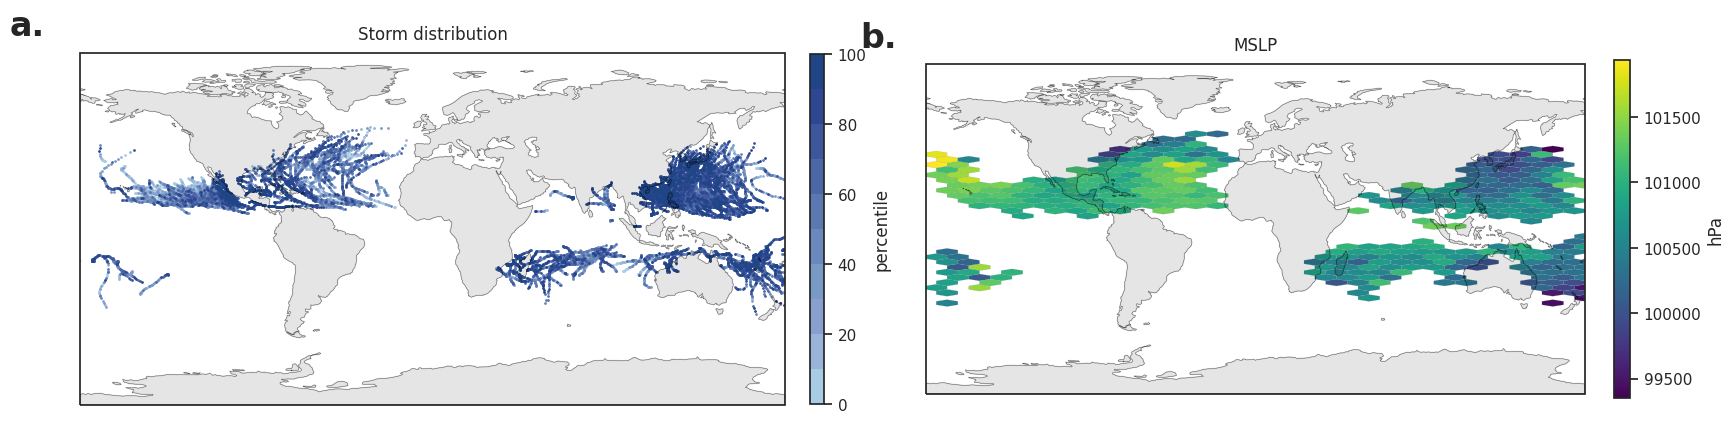

In [71]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, axes = plt.subplots(1,2,figsize=(20, 35),subplot_kw={'projection': ccrs.PlateCarree()})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

axes[0].scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=1,transform=ccrs.PlateCarree())
axes[0].scatter(p_100[:,5],p_100[:,4], color="#204587",s=1,transform=ccrs.PlateCarree())

axes[0].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[0].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[:,:,0],storm.storm_lats[:,:],storm.storm_lons[:,:])


# ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_title('Storm distribution',fontsize=12,pad=10)

levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
vmin=-2
vmax=2
width_ratios = [1,0.1]
# fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.PlateCarree()})
# ax[1].set_axis_off()
# ax.contourf(inputs[:,5],inputs[:,4],inputs[:,0],levels=range(98000,102000,500000), transform=ccrs.PlateCarree(),cmap='Oranges')
# im = ax.pcolormesh(inputs[:,5],inputs[:,4],inputs[:,0], cmap='viridis', transform=ccrs.PlateCarree())
x = inputs[:,5]
y = inputs[:,4]
z = inputs[:,0]
m = axes[1].hexbin(x,y, C=z, gridsize=30, cmap='viridis', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
axes[1].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[1].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
# gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)


axes[1].set_title('MSLP',fontsize=12,pad=10)
axes[1].set_global()
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
# levels=[ 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]

cb = plt.colorbar(m,fraction=0.024, pad=0.04,label='hPa')

# plt.savefig('figure_9d_mslp_distribution_4.png')
axes[0].set_global()
axes[1].set_global()
# axes[0].outline_patch.se t_linewidth(0.1)
# axes[1].patch.set_linewidth(0.1)

axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=24, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=24, weight='bold')

# Create a ListedColormap
colours = ["#A8CCE3","#98B5D9","#89A0CF","#799AC5","#6A88BB","#5B78B0","#4C67A6","#3E579C","#2F4792","#204587"]
cmap = ListedColormap(colours)

# Create a normalization instance to scale data to the range of the colormap
norm = Normalize(vmin=0, vmax=100)

# Create a colorbar using ColorbarBase
cbar_ax = fig.add_axes([0.49, 0.445, 0.007, 0.1])
cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical',label = 'percentile')



plt.savefig('figure_9c_storm_distribution_4.png',bbox_inches='tight')

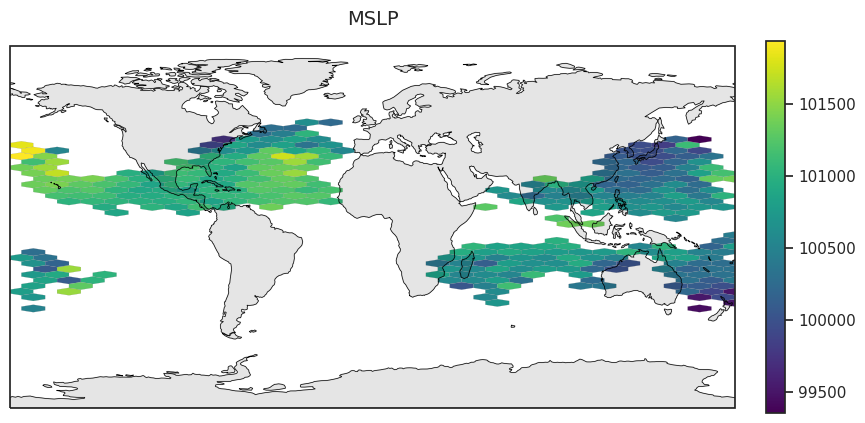

In [17]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2
width_ratios = [1,0.1]
fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.PlateCarree()})
# ax[1].set_axis_off()
# ax.contourf(inputs[:,5],inputs[:,4],inputs[:,0],levels=range(98000,102000,500000), transform=ccrs.PlateCarree(),cmap='Oranges')
# im = ax.pcolormesh(inputs[:,5],inputs[:,4],inputs[:,0], cmap='viridis', transform=ccrs.PlateCarree())
x = inputs[:,5]
y = inputs[:,4]
z = inputs[:,0]
m = ax.hexbin(x,y, C=z, gridsize=30, cmap='viridis', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('MSLP',fontsize=14,pad=15)
ax.set_global()
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
# levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]

cb = plt.colorbar(m,fraction=0.024, pad=0.04)

plt.savefig('figure_9d_mslp_distribution_4.png')

In [18]:
print(gen_pred.shape)
print(real.shape)

(15930, 100, 100, 20)
(15930, 100, 100, 1)


In [19]:
y_pred = gen_pred[0:16,:,:,0:1]
y_true = real[0:16,:,:,:]

In [20]:
print(y_pred.shape)
print(y_true.shape)

(16, 100, 100, 1)
(16, 100, 100, 1)


In [21]:
wloss = np.mean(y_true * y_pred, axis=-1)

In [22]:
print(wloss.shape)

(16, 100, 100)


In [23]:
y_max = np.max(y_true,axis=-1) + 0.1 # gamma 
image_relevance_weighting = y_true[:,:,:,0] / y_max # Wsod / gamma to get values bwteen 0 and 1
image_relevance_weighting = np.power(y_true[:,:,:,0],2) # because we are normalising by the max for demonstration then this is actually not giving higher values
image_relevance_weighting = y_true[:,:,:,0]
# weight_avg = K.ones((y_true.shape)) # Wavg is a matrix of ones because we don't want 0 weight on everything
weight_avg = np.ones_like(y_true[:,:,:,0])
weight_avg_2 = np.mean(y_true[:,:,:,0]) # this is to remove low distance bias over drizzle and no rain - so that even images will small rain are seen as the same as other images
weight = weight_avg + image_relevance_weighting
# weight = weight[:,:,:,0]
# sigma = np.sum(weight)
wloss = np.mean(y_true * y_pred, axis=-1)
# wloss_max = np.max(y_true * y_pred, axis=-1)
wwloss = wloss * weight + weight_avg_2
wloss_norm = wloss[0,:,:] * 1/np.max(wloss[0,:,:])
wwloss_norm = wwloss[0,:,:] * 1/np.max(wwloss[0,:,:])

wloss = wloss[0,:,:]
wwloss = wwloss[0,:,:]



In [24]:
print(image_relevance_weighting.shape)
print(weight_avg.shape)
print(weight.shape)
print(y_max[0,:,:])
print(np.max(weight[0,:,:]))
print(np.max(wloss))
print(np.max(wwloss))

print(np.mean(wloss))
print(np.mean(wwloss))

print(np.std(wloss_norm))
print(np.std(wwloss_norm))


(16, 100, 100)
(16, 100, 100)
(16, 100, 100)
[[0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 ...
 [0.66250001 0.66250001 0.66250001 ... 0.1625     0.1        0.1       ]
 [0.85000004 0.7875     0.7875     ... 0.1        0.1        0.1       ]
 [0.85000004 0.7875     0.7875     ... 0.1        0.1        0.1       ]]
22.125002208243583
244.9179492531132
4870.383995888031
4.6645253407027525
37.61204349458697
0.06186223648789901
0.0473922009963235


In [25]:
sns.set_style("white")
height_ratios = [1,0.1]
n = 2
m = 5
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.1, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
# axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

# Define a colormap (you can choose a different one if you prefer)
cmap = plt.get_cmap('BuPu')

# Create a normalization instance for the colormap
norm2 = mcolors.Normalize(vmin=0, vmax=1)
norm2 = mcolors.PowerNorm(vmin=0, vmax=np.max(wloss), gamma = 1/6)
norm3 = mcolors.PowerNorm(vmin=0, vmax=np.max(wwloss), gamma = 1/6)


im = axes[0,0].imshow(y_true[0,:,:], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(y_pred[0,:,:], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(wloss, interpolation='nearest', norm=norm2,extent=None,cmap=cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(weight[0,:,:], interpolation='nearest', norm=mcolors.Normalize(vmin=1, vmax=2),extent=None,cmap='RdPu')
axes[0,3].invert_yaxis()
axes[0,4].imshow(wwloss, interpolation='nearest',norm=norm3,extent=None,cmap=cmap)
axes[0,4].invert_yaxis()
# axes[0,5].imshow(pred_10[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
# axes[0,5].invert_yaxis()




fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9f_wloss_3.png',bbox_inches='tight',dpi=600)
plt.clf()

/tmp/ipykernel_155881/3457720115.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1010x400 with 0 Axes>

In [26]:
sorting = np.argsort(np.ravel(y_true[0,:,:]))
rain_sort = np.ravel(y_true)[sorting]
weightt = weight[0,:,:]
weight_sort = np.ravel(weightt)[sorting]
wloss_sort = np.ravel(wloss)[sorting]
wwloss_sort = np.ravel(wwloss)[sorting]

In [27]:
print(sorting)

[  35 5700 5701 ... 5090 5091 5092]


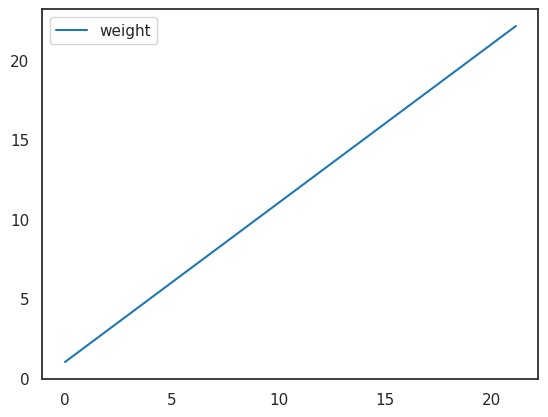

In [28]:
plt.plot(rain_sort,weight_sort)
# plt.plot(rain_sort,wloss_sort)
# plt.plot(rain_sort,wwloss_sort)
plt.legend(['weight','wloss','wwloss'])
# plt.yscale('log')
plt.show()